### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,\
    GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,\
    FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,\
    GradientBoostingClassifier, AdaBoostClassifier,\
    BaggingClassifier, ExtraTreesClassifier,\
    VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

import xgboost

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem Description

My goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. Specifically, I'll be predicting two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.

#### Business Problem 

Mayo Clinic: How can we predict who will be vaccinated? What are the most significant features? 

### Data

In [3]:
submission_format = pd.read_csv('../Data/submission_format.csv')
submission_format.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   respondent_id     26708 non-null  int64  
 1   h1n1_vaccine      26708 non-null  float64
 2   seasonal_vaccine  26708 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 626.1 KB


The submission_format.csv is an example of how my submission should be submitted.

In [4]:
test_set_features = pd.read_csv('../Data/test_set_features.csv')
test_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26623 non-null  float64
 2   h1n1_knowledge               26586 non-null  float64
 3   behavioral_antiviral_meds    26629 non-null  float64
 4   behavioral_avoidance         26495 non-null  float64
 5   behavioral_face_mask         26689 non-null  float64
 6   behavioral_wash_hands        26668 non-null  float64
 7   behavioral_large_gatherings  26636 non-null  float64
 8   behavioral_outside_home      26626 non-null  float64
 9   behavioral_touch_face        26580 non-null  float64
 10  doctor_recc_h1n1             24548 non-null  float64
 11  doctor_recc_seasonal         24548 non-null  float64
 12  chronic_med_condition        25776 non-null  float64
 13  child_under_6_mo

The test_set_features.csv will be used to run my model and produce a predictive csv in the format of submission_format. 

In [5]:
training_set_features = pd.read_csv('../Data/training_set_features.csv')
training_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [6]:
training_set_labels = pd.read_csv('../Data/training_set_labels.csv')
training_set_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


The training_set_features and is the dataset used to predict the actual training_set_labels. They are already split, however I will be rejoining for any cleaning I find necessary and splitting again in a format that is more convenient since there is two target variables. 

In [7]:
complete_data = pd.merge(training_set_features, training_set_labels, on='respondent_id')

In [8]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [9]:
complete_data.isna().sum().sort_values(ascending=False)

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_adults                 249
household_children               249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowledge                   116
h1n1_concern                      92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

If the employment_status column has a value of Not in Labor Force, then columns employment_industry and employment_occupation will have NA's. 

Values in columns employment_industry and employment_occupation are represented as short random character strings. 

Filling NA's in employment_occupation and employment_industry associated with "not in labor force" with because they would otherwise be imputed as the most frequent occupation or industry.

Filling Unemployed with "not in labor force".

In [10]:
complete_data['employment_status'].replace("Unemployed", "Not in Labor Force", inplace=True)
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_industry'] = "Not in Labor Force"
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "Not in Labor Force"

In [11]:
complete_data.filter(['employment_status', 'employment_occupation', 'employment_industry'])

,employment_status,employment_occupation,employment_industry
0,Not in Labor Force,Not in Labor Force,Not in Labor Force
1,Employed,xgwztkwe,pxcmvdjn
2,Employed,xtkaffoo,rucpziij
3,Not in Labor Force,Not in Labor Force,Not in Labor Force
4,Employed,emcorrxb,wxleyezf
...,...,...,...
26702,Not in Labor Force,Not in Labor Force,Not in Labor Force
26703,Employed,cmhcxjea,fcxhlnwr
26704,NaN,NaN,NaN
26705,Employed,haliazsg,fcxhlnwr


### Split

Creating two splits for each target variable.

In [12]:
X = complete_data.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y1 = complete_data.filter(['h1n1_vaccine'])
y2 = complete_data.filter(['seasonal_vaccine'])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.33, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.33, random_state=42)

In [13]:
y_train1.value_counts(normalize=True)

h1n1_vaccine
0               0.787291
1               0.212709
dtype: float64

In [14]:
y_train2.value_counts()

seasonal_vaccine
0                   9502
1                   8391
dtype: int64

#### Numeric Pipeline for Column Transformer

All columns are in a categorical format, however, some are scales and may better be represented as numeric columns.

Possible numeric columns: h1n1_concern, h1n1_knowledge, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, and opinion_seas_sick_from_vacc.

In [15]:
num_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

In [16]:
X[num_cols].describe()

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
count,26615.000000,26591.000000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000
mean,1.618486,1.262532,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112
std,0.910311,0.618149,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000
50%,2.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000
75%,2.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000
max,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [17]:
X[num_cols].median()

h1n1_concern                   2.0
h1n1_knowledge                 1.0
opinion_h1n1_vacc_effective    4.0
opinion_h1n1_risk              2.0
opinion_h1n1_sick_from_vacc    2.0
opinion_seas_vacc_effective    4.0
opinion_seas_risk              2.0
opinion_seas_sick_from_vacc    2.0
dtype: float64

In [18]:
# def grab_numeric(df):
#     return df.select_dtypes(include=['float', 'int'])

In [19]:
# The FunctionTransformer will turn my function
# into a transformer.
# GrabNumeric = FunctionTransformer(grab_numeric)

In [20]:
# # Pipe!

# pipe = Pipeline(steps=[
#     ('num', GrabNumeric),
#     ('ss', StandardScaler())
# ])

#### Using `Pipeline` and `ColumnTransformer`

In [21]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,Not in Labor Force,Not in Labor Force
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,Not in Labor Force,Not in Labor Force
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [22]:
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')) ])

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                              ('ss', StandardScaler()) ])

In [23]:
# cat_cols = []
# ord_cols = []

In [24]:
# for col in X.columns:
#     if len(X[col].value_counts().index) > 2:
#         cat_cols.append(col)
#     else:
#         ord_cols.append(col)

In [25]:
# columns = list(X.columns)
# columns

In [26]:
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc']

In [27]:
cat_cols = X.columns.drop(num_cols)
cat_cols

Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'employment_industry', 'employment_occupation'],
      dtype='object')

In [28]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.
ct = ColumnTransformer(transformers = [
    ('subpipe_cat', subpipe_cat, cat_cols),
    ('subpipe_num', subpipe_num, num_cols)
])

#### Logistic Regression Pipeline

In [29]:
logreg_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

The .values.ravel() removes warnings.

In [30]:
y_train1 = y_train1.values.ravel()

In [31]:
logreg_model_pipe.fit(X_train1, y_train1);

In [32]:
logreg_model_pipe.score(X_train1, y_train1)

0.8374783434862796

In [33]:
cross_val_score(logreg_model_pipe, X_train1, y_train1)

array([0.83403185, 0.83598771, 0.83487008, 0.83426495, 0.8373393 ])

In [34]:
y_train2 = y_train2.values.ravel()

In [35]:
logreg_model_pipe.fit(X_train2, y_train2);

In [36]:
logreg_model_pipe.score(X_train2, y_train2)

0.7805845861510088

In [37]:
cross_val_score(logreg_model_pipe, X_train2, y_train2)

array([0.77395921, 0.78234144, 0.76613579, 0.77697037, 0.78283958])

#### Bringing in Our Modeling Class from before

In [38]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [39]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train1, y=y_train1)

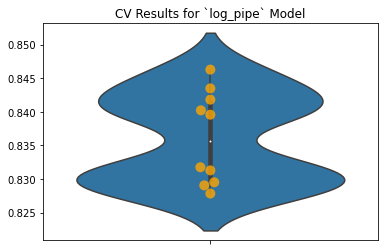

In [40]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax);

In [41]:
log_pipe.print_cv_summary()

CV Results for `log_pipe` model:
            0.83608 ± 0.00651 accuracy
        


In [42]:
logreg_model_pipe.fit(X_train1, y_train1)
y_hat = logreg_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.43 

Our final model's precision on the test set is 0.69 

Our final model's f1-score on the test is 0.53.



##### Logistic Regression Tuning

In [ ]:
LogisticRegression()

In [147]:
params = {}

params['logreg__solver'] = ['liblinear', 'sag']
params['logreg__C'] = [.1,.3,.5]
params['logreg__max_iter'] = [50, 100, 150]

In [148]:
gs_log = GridSearchCV(estimator=logreg_model_pipe, param_grid=params, cv=10)

In [149]:
gs_log.fit(X_train1, y_train1);

In [150]:
gs_log.cv_results_['mean_test_score']

array([0.83608161, 0.83574632, 0.83608161, 0.83574632, 0.83608161,
       0.83574632, 0.83591386, 0.83563453, 0.83591386, 0.83563453,
       0.83591386, 0.83563453, 0.83585799, 0.83569042, 0.83585799,
       0.83569042, 0.83585799, 0.83569042])

In [151]:
gs_log.best_params_

{'logreg__C': 0.1, 'logreg__max_iter': 50, 'logreg__solver': 'liblinear'}

Best parameters  for logreg: 'logreg__C': 0.1, 'logreg__solver': 'sag'

In [48]:
gs_log.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings',...
                                                  Pipeline(steps=[('num_impute',
                                                            

#### Nearest Neighbors Pipeline

In [49]:
pd.DataFrame(ct.fit_transform(X_train1)).describe()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
count,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,17893.000000,...,17893.000000,17893.000000,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04,1.789300e+04
mean,0.048902,0.725591,0.069692,0.821942,0.356564,0.337898,0.675124,0.203487,0.306041,0.275136,...,0.065445,0.009277,2.422350e-17,-1.052332e-16,3.027937e-17,7.981841e-17,-5.956598e-18,5.797756e-17,1.111898e-17,-4.487304e-17
std,0.215669,0.446228,0.254634,0.382573,0.478998,0.473007,0.468341,0.402603,0.460860,0.446595,...,0.247316,0.095874,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.788306e+00,-2.049421e+00,-2.853217e+00,-1.051483e+00,-1.002707e+00,-2.833489e+00,-1.245505e+00,-8.452392e-01
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-6.865928e-01,-4.259798e-01,-8.528797e-01,-1.051483e+00,-1.002707e+00,-3.039182e-02,-5.188961e-01,-8.452392e-01
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.151205e-01,-4.259798e-01,1.472892e-01,-2.704224e-01,-2.659226e-01,-3.039182e-02,-5.188961e-01,-8.946163e-02
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,4.151205e-01,1.197462e+00,1.147458e+00,1.291698e+00,1.207646e+00,9.039739e-01,9.343216e-01,-8.946163e-02
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.516834e+00,1.197462e+00,1.147458e+00,2.072758e+00,1.944430e+00,9.039739e-01,1.660931e+00,2.177871e+00


In [50]:
knn = KNeighborsClassifier()
knn_model_pipe = Pipeline([('ct', ct), ('knn', knn)]) 
#Need StandardScaler? No features are numeric

In [51]:
knn_model_pipe.fit(X_train1, y_train1);

In [52]:
knn_pipe = ModelWithCV(knn_model_pipe, 'knn_pipe', X_train1, y_train1)

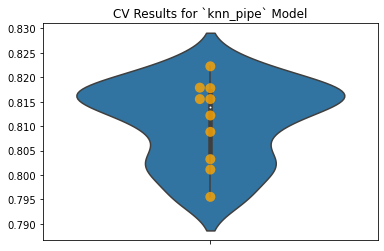

In [53]:
fig, ax = plt.subplots()

knn_pipe.plot_cv(ax=ax);

In [54]:
knn_pipe.print_cv_summary()

CV Results for `knn_pipe` model:
            0.81099 ± 0.00815 accuracy
        


In [55]:
knn_model_pipe.fit(X_train1, y_train1)
y_hat = knn_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.86. 

Our final model's recall on the test set is 0.48 

Our final model's precision on the test set is 0.77 

Our final model's f1-score on the test is 0.59.



##### Nearest Neighbors Tuning

In [56]:
params = {}

params['knn__metric'] = ['euclidean', 'manhattan']
params['knn__n_neighbors'] = [10, 15, 20]

In [57]:
gs_knn = GridSearchCV(estimator=knn_model_pipe, param_grid=params, cv=10)

In [58]:
gs_knn.fit(X_train1, y_train1);

In [59]:
gs_knn.cv_results_['mean_test_score']

array([0.8182532 , 0.82166271, 0.82071217, 0.81897961, 0.82166218,
       0.81925913])

In [60]:
gs_knn.best_params_

{'knn__metric': 'euclidean', 'knn__n_neighbors': 15}

knn best perameters: 'knn__metric': 'euclidean', 'knn__n_neighbors': 15

#### Random Forest Pipeline

In [61]:
# rfc!
rfc = RandomForestClassifier(random_state=42)
rfc_model_pipe = Pipeline([('ct', ct), ('rfc', rfc)])

In [62]:
rfc_model_pipe.fit(X_train1, y_train1);

In [63]:
forest_pipe = ModelWithCV(rfc_model_pipe, 'forest_pipe', X_train1, y_train1)

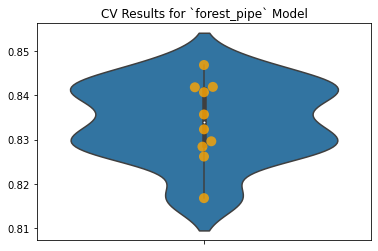

In [64]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [65]:
forest_pipe.print_cv_summary()

CV Results for `forest_pipe` model:
            0.83401 ± 0.00865 accuracy
        


In [66]:
rfc_model_pipe.fit(X_train1, y_train1)
y_hat = rfc_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 1.0. 

Our final model's recall on the test set is 1.0 

Our final model's precision on the test set is 1.0 

Our final model's f1-score on the test is 1.0.



Overfit for sure

##### Random Forest Tuning

In [67]:
params = {}

params['rfc__max_features'] = ['sqrt', 'auto']
params['rfc__n_estimators'] = [100, 1000, 1500]

In [68]:
gs_rfc = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10)

In [69]:
gs_rfc.fit(X_train1, y_train1);

In [70]:
gs_rfc.cv_results_['mean_test_score']

array([0.83401407, 0.83703205, 0.83675263, 0.83401407, 0.83703205,
       0.83675263])

In [71]:
gs_rfc.best_params_

{'rfc__max_features': 'sqrt', 'rfc__n_estimators': 1000}

Random Forest best params: 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 1000

#### Gradient Booster

In [72]:
gbc = GradientBoostingClassifier(random_state=42)
gbc_model_pipe = Pipeline([('ct', ct), ('gbc', gbc)])

In [73]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train1,
                         y=y_train1)

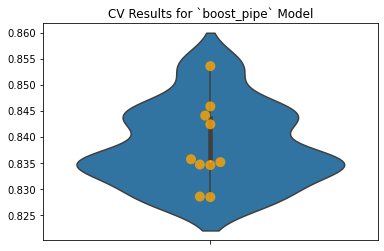

In [74]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax);

In [75]:
boost_pipe.print_cv_summary()

CV Results for `boost_pipe` model:
            0.83826 ± 0.00760 accuracy
        


In [76]:
gbc_model_pipe.fit(X_train1, y_train1)
y_hat = gbc_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.85. 

Our final model's recall on the test set is 0.46 

Our final model's precision on the test set is 0.71 

Our final model's f1-score on the test is 0.56.



##### Gradient Booster Tuning

In [77]:
params = {}

params['gbc__learning_rate'] = [.025, .05, .1]
params['gbc__n_estimators'] = [300, 350, 400]

In [78]:
gs_gbc = GridSearchCV(estimator=gbc_model_pipe, param_grid=params, cv=10)

In [79]:
gs_gbc.fit(X_train1, y_train1);

In [80]:
gs_gbc.cv_results_['mean_test_score']

array([0.83697578, 0.83759058, 0.83859648, 0.83971439, 0.84010561,
       0.84032923, 0.83921129, 0.83993814, 0.83859708])

In [81]:
gs_gbc.best_params_

{'gbc__learning_rate': 0.05, 'gbc__n_estimators': 400}

Gradient Booster best parmeters: 'gbc__learning_rate': 0.05, 'gbc__n_estimators': 400

#### AdaBoost 

In [82]:
ada = AdaBoostClassifier()
ada_model_pipe = Pipeline([('ct', ct), ('ada', ada)])

In [83]:
ada_pipe = ModelWithCV(model=ada_model_pipe,
                         model_name='ada_pipe',
                         X=X_train1,
                         y=y_train1)

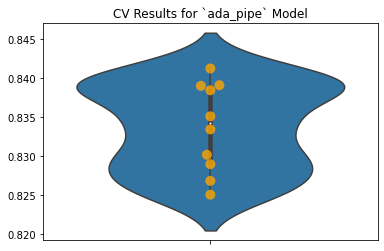

In [84]:
fig, ax = plt.subplots()

ada_pipe.plot_cv(ax=ax);

In [85]:
ada_pipe.print_cv_summary()

CV Results for `ada_pipe` model:
            0.83373 ± 0.00545 accuracy
        


In [86]:
ada_model_pipe.fit(X_train1, y_train1)
y_hat = ada_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.44 

Our final model's precision on the test set is 0.68 

Our final model's f1-score on the test is 0.53.



##### Adaboost Tuning

In [87]:
params = {}

params['ada__learning_rate'] = [.25, .5, .75]
params['ada__n_estimators'] = [250, 300, 350]

In [88]:
gs_ada = GridSearchCV(estimator=ada_model_pipe, param_grid=params, cv=10)

In [89]:
gs_ada.fit(X_train1, y_train1);

In [90]:
gs_ada.cv_results_['mean_test_score']

array([0.83496379, 0.83490777, 0.83552258, 0.83552251, 0.83574613,
       0.83574613, 0.83563446, 0.83591379, 0.83591386])

In [91]:
gs_ada.best_params_

{'ada__learning_rate': 0.75, 'ada__n_estimators': 350}

Adaboost best parameters: 'ada__learning_rate': .75, 'ada__n_estimators': 350

#### XGBoost 

In [92]:
xgb = xgboost.XGBClassifier(random_state=42)
xgb_model_pipe = Pipeline([('ct', ct), ('xgb', xgb)])

In [93]:
xgb_pipe = ModelWithCV(model=xgb_model_pipe,
                         model_name='xgb_pipe',
                         X=X_train1,
                         y=y_train1)

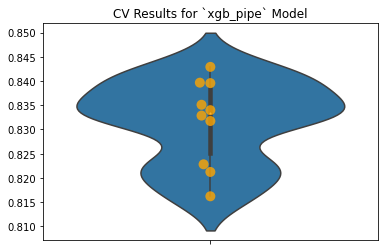

In [94]:
fig, ax = plt.subplots()

xgb_pipe.plot_cv(ax=ax);

In [95]:
xgb_pipe.print_cv_summary()

CV Results for `xgb_pipe` model:
            0.83161 ± 0.00836 accuracy
        


In [96]:
xgb_model_pipe.fit(X_train1, y_train1)
y_hat = xgb_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.91. 

Our final model's recall on the test set is 0.68 

Our final model's precision on the test set is 0.88 

Our final model's f1-score on the test is 0.77.



^ Nice! Watch for overfitting.

#### Extra Trees Classifier

In [97]:
etc = ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42)
etc_model_pipe = Pipeline([('ct', ct), ('etc', etc)])

In [98]:
etc_pipe = ModelWithCV(model=etc_model_pipe,
                         model_name='etc_pipe',
                         X=X_train1,
                         y=y_train1)

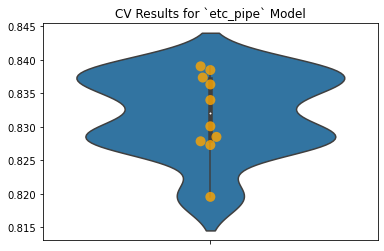

In [99]:
fig, ax = plt.subplots()

etc_pipe.plot_cv(ax=ax);

In [100]:
etc_pipe.print_cv_summary()

CV Results for `etc_pipe` model:
            0.83183 ± 0.00594 accuracy
        


In [101]:
etc_model_pipe.fit(X_train1, y_train1)
y_hat = etc_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.96. 

Our final model's recall on the test set is 0.8 

Our final model's precision on the test set is 1.0 

Our final model's f1-score on the test is 0.89.



^ Nice! Watch for overfitting. 

#### Bagging

In [102]:
bag = BaggingClassifier(n_estimators=100, random_state=42)
bag_model_pipe = Pipeline([('ct', ct), ('bag', bag)])

In [103]:
bag_pipe = ModelWithCV(model=bag_model_pipe,
                         model_name='bag_pipe',
                         X=X_train1,
                         y=y_train1)

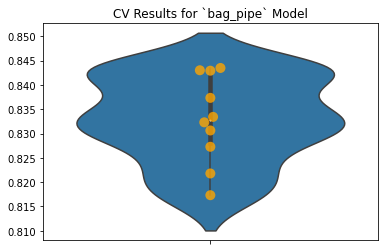

In [104]:
fig, ax = plt.subplots()

bag_pipe.plot_cv(ax=ax);

In [105]:
bag_pipe.print_cv_summary()

CV Results for `bag_pipe` model:
            0.83295 ± 0.00859 accuracy
        


In [106]:
bag_model_pipe.fit(X_train1, y_train1)
y_hat = bag_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 1.0. 

Our final model's recall on the test set is 1.0 

Our final model's precision on the test set is 1.0 

Our final model's f1-score on the test is 1.0.



Overfit, for sure

### Ensembles

#### Voting Classifier

##### Voting Classifier 1

In [107]:
avg1 = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=1000, C=.1, solver='sag')),
    ('knn', KNeighborsClassifier(metric= 'euclidean', n_neighbors= 15)),
    ('rfc', RandomForestClassifier(max_features= 'sqrt', n_estimators= 1000))    
])
avg1_model_pipe = Pipeline([('ct', ct), ('avg1', avg1)])

In [108]:
avg1_pipe = ModelWithCV(model=avg1_model_pipe,
                         model_name='avg1_pipe',
                         X=X_train1,
                         y=y_train1)

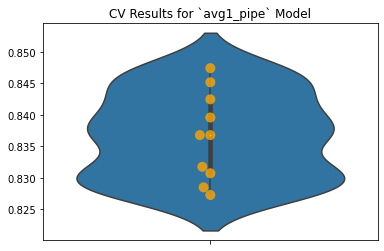

In [109]:
fig, ax = plt.subplots()

avg1_pipe.plot_cv(ax=ax);

In [110]:
avg1_pipe.print_cv_summary()

CV Results for `avg1_pipe` model:
            0.83664 ± 0.00666 accuracy
        


In [111]:
avg1_model_pipe.fit(X_train1, y_train1)
y_hat = avg1_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.87. 

Our final model's recall on the test set is 0.49 

Our final model's precision on the test set is 0.86 

Our final model's f1-score on the test is 0.62.



Eh, we can probably do better.

##### Voting Classifier 2

In [112]:
avg2 = VotingClassifier(estimators=[
    ('gbc', GradientBoostingClassifier(random_state=42, learning_rate= 0.1, n_estimators= 250)),
    ('ada', AdaBoostClassifier(learning_rate= .5, n_estimators= 300)),
    ('xgb', xgb)    
])
avg2_model_pipe = Pipeline([('ct', ct), ('avg2', avg2)])

In [113]:
avg2_pipe = ModelWithCV(model=avg2_model_pipe,
                         model_name='avg2_pipe',
                         X=X_train1,
                         y=y_train1)

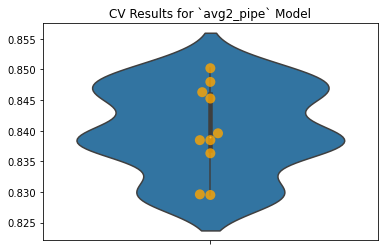

In [114]:
fig, ax = plt.subplots()

avg2_pipe.plot_cv(ax=ax);

In [115]:
avg2_pipe.print_cv_summary()

CV Results for `avg2_pipe` model:
            0.84016 ± 0.00686 accuracy
        


In [116]:
avg2_model_pipe.fit(X_train1, y_train1)
y_hat = avg2_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.86. 

Our final model's recall on the test set is 0.5 

Our final model's precision on the test set is 0.76 

Our final model's f1-score on the test is 0.6.



Eh, about the same.

##### Voting Classifier 3

In [117]:
avg3 = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=1000, C=.1, solver='sag')),
    ('knn', KNeighborsClassifier(metric= 'euclidean', n_neighbors= 15)),
    ('rfc', RandomForestClassifier(max_features= 'sqrt', n_estimators= 1000)),
    ('gbc', GradientBoostingClassifier(random_state=42, learning_rate= 0.1, n_estimators= 250)),
    ('ada', AdaBoostClassifier(learning_rate= 1.5, n_estimators= 250)),
    ('xgb', xgb)
])
avg3_model_pipe = Pipeline([('ct', ct), ('avg3', avg3)])

In [118]:
avg3_pipe = ModelWithCV(model=avg3_model_pipe,
                         model_name='avg3_pipe',
                         X=X_train1,
                         y=y_train1)

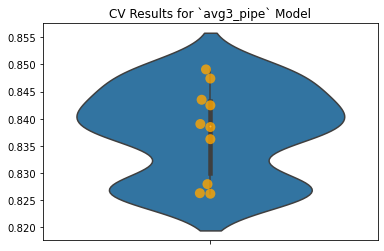

In [119]:
fig, ax = plt.subplots()

avg3_pipe.plot_cv(ax=ax);

In [120]:
avg3_pipe.print_cv_summary()

CV Results for `avg3_pipe` model:
            0.83765 ± 0.00802 accuracy
        


In [121]:
avg3_model_pipe.fit(X_train1, y_train1)
y_hat = avg3_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.86. 

Our final model's recall on the test set is 0.46 

Our final model's precision on the test set is 0.82 

Our final model's f1-score on the test is 0.59.



#### Weighted Voting Classifier

#### Stacking

##### Stack 1

In [122]:
estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=1000, C=.1, solver='sag')),
    ('knn', KNeighborsClassifier(metric= 'euclidean', n_neighbors= 15)),
    ('rfc', RandomForestClassifier(max_features= 'sqrt', n_estimators= 1000)) 
]

In [123]:
sr1 = StackingClassifier(estimators)
sr1_model_pipe = Pipeline([('ct', ct), ('sr1', sr1)])

In [124]:
sr1_pipe = ModelWithCV(model=sr1_model_pipe,
                         model_name='sr1_pipe',
                         X=X_train1,
                         y=y_train1)

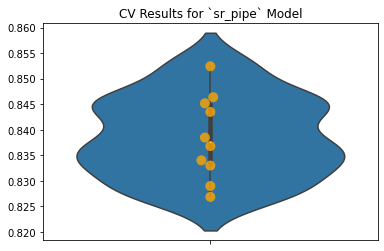

In [125]:
fig, ax = plt.subplots()

sr1_pipe.plot_cv(ax=ax);

In [126]:
sr1_pipe.print_cv_summary()

CV Results for `sr_pipe` model:
            0.83854 ± 0.00779 accuracy
        


In [127]:
sr1_model_pipe.fit(X_train1, y_train1)
y_hat = sr1_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.96. 

Our final model's recall on the test set is 0.83 

Our final model's precision on the test set is 0.98 

Our final model's f1-score on the test is 0.89.



^ Too good to be true?

##### Stack 2

In [152]:
estimators=[
    ('logreg', LogisticRegression(random_state=42, max_iter=50, C=.1, solver='liblinear')),
    ('knn', KNeighborsClassifier(metric= 'euclidean', n_neighbors= 15)),
    ('rfc', RandomForestClassifier(max_features= 'sqrt', n_estimators= 1000)),
    ('etc', etc)
]

In [153]:
sr2 = StackingClassifier(estimators)
sr2_model_pipe = Pipeline([('ct', ct), ('sr2', sr2)])

In [154]:
sr2_pipe = ModelWithCV(model=sr2_model_pipe,
                         model_name='sr2_pipe',
                         X=X_train1,
                         y=y_train1)

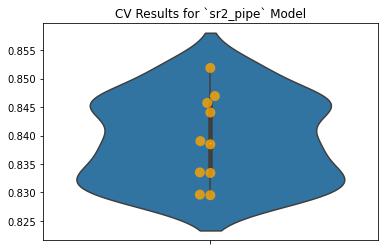

In [155]:
fig, ax = plt.subplots()

sr2_pipe.plot_cv(ax=ax);

In [156]:
sr2_pipe.print_cv_summary()

CV Results for `sr2_pipe` model:
            0.83921 ± 0.00734 accuracy
        


In [157]:
sr2_model_pipe.fit(X_train1, y_train1)
y_hat = sr2_model_pipe.predict(X_train1)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.96. 

Our final model's recall on the test set is 0.81 

Our final model's precision on the test set is 0.97 

Our final model's f1-score on the test is 0.89.



### Tune again?

### Evaluation on Test Set

In [128]:
final_model1 = sr1_model_pipe

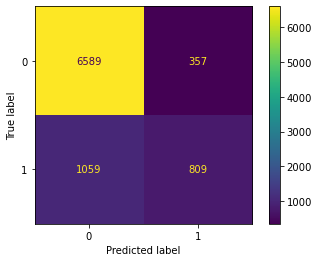

In [129]:
plot_confusion_matrix(final_model1, X_test1, y_test1);

In [130]:
y_hat = final_model1.predict(X_test1)

In [131]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.43 

Our final model's precision on the test set is 0.69 

Our final model's f1-score on the test is 0.53.



In [184]:
y_hat = final_model1.predict_proba(X_test1)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test1, y_hat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.169521, G-Mean=0.759


In [185]:
y_hat = (final_model1.predict_proba(X_test1)[:,1] >= thresholds[ix]).astype(bool)

In [186]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.78. 

Our final model's recall on the test set is 0.73 

Our final model's precision on the test set is 0.48 

Our final model's f1-score on the test is 0.58.



Final part 2

In [158]:
final_model2 = sr2_model_pipe

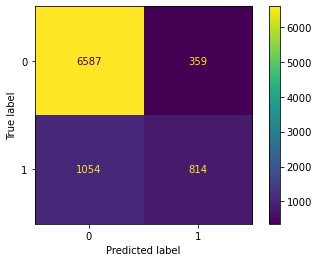

In [193]:
plot_confusion_matrix(final_model2, X_test1, y_test1);

In [182]:
y_hat = final_model2.predict(X_test1)

In [183]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.84. 

Our final model's recall on the test set is 0.44 

Our final model's precision on the test set is 0.69 

Our final model's f1-score on the test is 0.54.



In [170]:
y_hat = (final_model2.predict_proba(X_test1)[:,1] >= 0.3).astype(bool)

array([0.11851444, 0.09301922, 0.07397352, ..., 0.05694896, 0.17189974,
       0.06768461])

In [168]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.83. 

Our final model's recall on the test set is 0.59 

Our final model's precision on the test set is 0.59 

Our final model's f1-score on the test is 0.59.



In [177]:
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
from sklearn.metrics import roc_curve
from numpy import sqrt, argmax

In [178]:
y_hat = final_model2.predict_proba(X_test1)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test1, y_hat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.163313, G-Mean=0.758


In [180]:
y_hat = (final_model2.predict_proba(X_test1)[:,1] >= thresholds[ix]).astype(bool)

array([False, False, False, ..., False,  True, False])

In [181]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test1, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test1, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test1, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test1, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.77. 

Our final model's recall on the test set is 0.74 

Our final model's precision on the test set is 0.47 

Our final model's f1-score on the test is 0.58.

